# AirBnb Berlin Dataset

Berlin Airbnb data publicly available at [InsideAirbnb](http://insideairbnb.com/berlin)

## Kickoff Questions
1. How does number of rooms influence review scoring and pricing ? 
2. How do amenities impact in the review scoring ?  
3. How did prices evolve over time?

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
# listings of April 2020
df_listings = pd.read_csv('datasets/listings_2020-04-17.csv', low_memory=False)
df_listings.head()

## Data Understanding and Prepare Data

In [178]:
df_listings['float_price'] = df_listings['price'].str.replace('[$\,]','').astype('float64')
df = df_listings.dropna(axis=1, how='all')
df = df[df['float_price'] != 0.0]

Below is the correlation between quantitative features with overall review score and price.

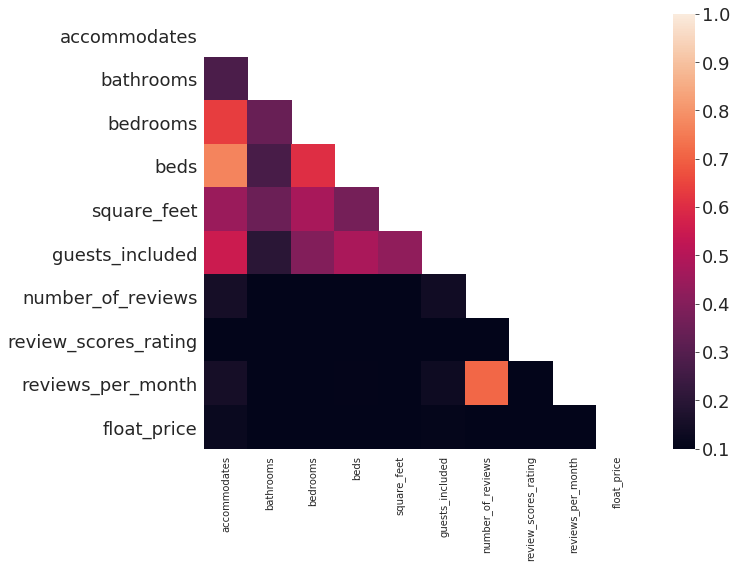

In [179]:
import seaborn as sns
df = df[
    ['accommodates', 'bathrooms',
     'bedrooms', 'beds',
     'square_feet', 'guests_included',
     'number_of_reviews', 'review_scores_rating',
     'reviews_per_month', 'float_price']
]
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(corr, mask=mask, vmin=.1, square=True)

When we look at `float price` and `review_scores_rating` we see that those have very low correlation with everything else. We conclude that price and review score are not heavily influenced by space aspects.

## Data Modeling

### How do amenities impact in the final review score of each listing ?

Following are the questions I will explore in this section
1. How do prices vary per neigborhood ?
2. What neighborhood has the most expensive listings ?
3. What does differ a expensive listing to a cheap listing in terms of amenities? What are the most popular amenities?


Shown below are the top 10 **most** and **less** expensive neighbourhoods by listing price in average.

In [180]:
df_grouped = df_listings.groupby('neighbourhood')['float_price']

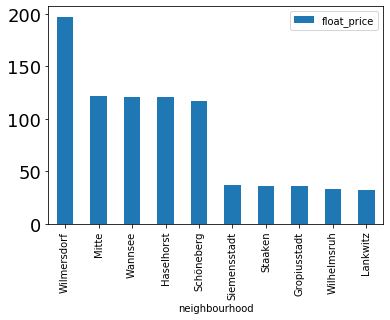

In [181]:
# sort neighbourhoods by price
df_mean = df_grouped.mean().sort_values(ascending=False)
df_mean = df_mean.reset_index()
df_mean = pd.concat([df_mean[:5], df_mean[-5:]])
df_mean.plot.bar(x='neighbourhood')

Shown below are the amenities present in more than 50% of listings in the 10 more expensive neighbourhoods

In [182]:
# select popular amenities among listings in the most expensive neighbourhoods
indexer = [item in list(df_mean[:10]['neighbourhood']) for item in df_listings['neighbourhood']]
df_expensive_neig = df_listings[indexer]
number_of_listings = df_expensive_neig.shape[0]

df_amenities = df_expensive_neig['amenities']
df_amenities = pd.DataFrame([elem.replace('{','').replace('}', '').replace('"','').split(',') for elem in df_amenities])
df_amenities = pd.DataFrame(df_amenities.values.flatten())
df_amenities = df_amenities.dropna()

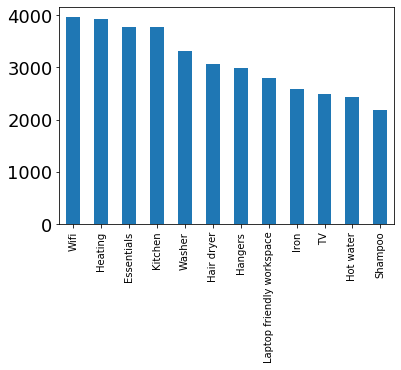

In [183]:
amenitites_counts = df_amenities[0].value_counts()
top_amenities = amenitites_counts[[count/number_of_listings > .5 for count in amenitites_counts]]
ax = top_amenities.plot.bar()

Shown below are the amenities present in more than 50% of listings in the 10 less expensive neighbourhoods

In [184]:
# select popular amenities among listings in the less expensive neighbourhoods
indexer = [item in list(df_mean[-10:]['neighbourhood']) for item in df_listings['neighbourhood']]
df_cheap_neig = df_listings[indexer]
number_of_listings = df_cheap_neig.shape[0]

df_amenities = df_cheap_neig['amenities']
df_amenities = pd.DataFrame([elem.replace('{','').replace('}', '').replace('"','').split(',') for elem in df_amenities])
df_amenities = pd.DataFrame(df_amenities.values.flatten())
df_amenities = df_amenities.dropna()

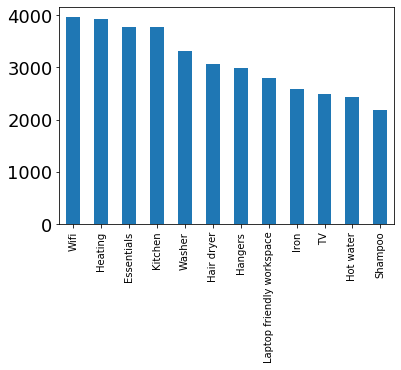

In [185]:
amenitites_counts = df_amenities[0].value_counts()
top_amenities = amenitites_counts[[count/number_of_listings > .5 for count in amenitites_counts]]
ax = top_amenities.plot.bar()

Amenities do not have huge impact on price. Nevertheless, there is a set of essential things you **MUST** have in your accomdation.

## How did prices evolve over time?  

**Note:** Data from previous months/year is required

In [186]:
dates = [
    # 2020
    ['2020-04-17'], ['2020-03-17'], ['2020-02-18'],
    ['2020-01-10'],
    # 2019
    ['2019-12-11'], ['2019-11-12'], ['2019-10-16'], 
    ['2019-09-19'], ['2019-08-12'], ['2019-07-11'],
    ['2019-06-08'], ['2019-05-14'], ['2019-04-11'], 
    ['2019-03-08'], ['2019-02-06'], ['2019-01-14'], 
    # 2018
    ['2018-12-10'], ['2018-11-07'], ['2018-10-10'], 
    ['2018-09-12'], ['2018-08-14'], ['2018-07-10'],
    ['2018-06-09'], ['2018-05-14'], ['2018-04-12'], 
    # 2017
    ['2017-05-08'], ['2017-04-08'], ['2017-03-06'], 
    ['2017-02-10'], ['2017-01-06'],
    # 2016
    ['2016-12-08'], ['2016-11-07'], ['2016-10-04'], 
    ['2016-09-05'], ['2016-08-04'], ['2016-07-05'],
    ['2016-06-03'], ['2016-05-03'], ['2016-04-04'], 
    ['2016-02-04'], ['2016-01-04'], 
    # 2015
    ['2015-12-05'], ['2015-11-08'], ['2015-10-03']
]

def get_mean(date):
    """
    Read the appropiate csv base on the date and return the mean of the column price.
    """
    df = pd.read_csv(f"datasets/listings_{date}.csv", low_memory=False)
    df['float_price'] = df['price'].str.replace('[$\,]','').astype('float64')
    return df['float_price'].mean()

def get_month(month_of_year):
    """
    Return a month as an abbreviated string given a number between 1 and 12. 
    """
    months = {
        '01': 'Jan', '02': 'Feb', '03': 'Mar',
        '04': 'Apr', '05': 'May', '06': 'Jun',
        '07': 'Jul', '08': 'Aug', '09': 'Sep',
        '1': 'Jan', '2': 'Feb', '3': 'Mar',
        '4': 'Apr', '5': 'May', '6': 'Jun',
        '7': 'Jul', '8': 'Aug', '9': 'Sep',
        '10': 'Oct', '11': 'Nov', '12': 'Dec',
    }
    return months[month_of_year]

def labelize_as_year_month(date):
    """
    Return a formatted string with year and month both abbreviated
    """
    date = pd.to_datetime(date)
    label = date.strftime('%Y %m')
    label = label[2::]
    return label[:-2] + get_month(label[-2:])

df = pd.DataFrame([[labelize_as_year_month(date[0]), get_mean(date[0])] for date in reversed(dates)], columns=['date','mean'])

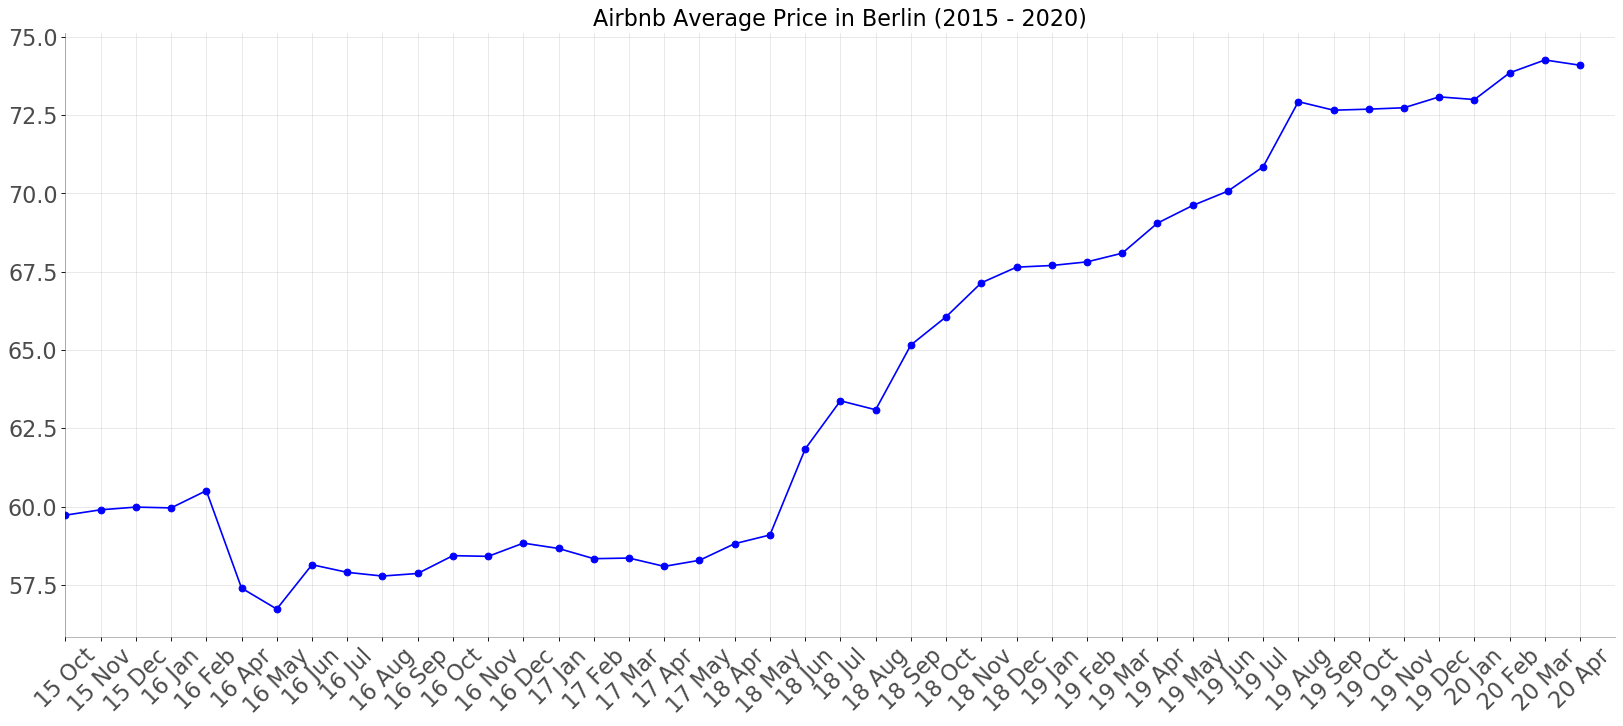

In [187]:
# draw plot
plt.figure(figsize=(25,10), dpi= 80)
plt.plot('date', 'mean', 'bo-', data=df)

# decoration
plt.xticks(ticks=range(0,df.shape[0]),labels=df['date'], rotation=45, fontsize=20, alpha=.7)
plt.yticks(fontsize=20, alpha=.7)
plt.title("Airbnb Average Price in Berlin (2015 - 2020)", fontsize=20)
plt.grid(axis='both', alpha=.3)

# remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)
plt.xlim([0,df.shape[0]])
plt.show()

In [188]:
(1 - df['mean'][0] / df['mean'][df.shape[0]-1])*100 # average price increase


19.389211074099677

In [189]:
(1- 122.033/174.85)*100 # housing index

30.207034601086647

In [190]:
 (1 - 0.3/0.8)*100 # inflation rate

62.5

Airbnb prices in Berlin increases 19%, while the housing index has increased 30% in the same period. Renting index has increased 33% for existings buildings and 45.20% for new buildings in the last five years. It shows that Airbnb prices increases slowly compared to housing/renting indexes.

Sources: 
* https://tradingeconomics.com/germany/housing-index
* https://guthmann.estate/en/market-report/berlin/#rent

In [191]:
# months of 2019
dates_19 = [
    ['2019-12-11'], ['2019-11-12'], ['2019-10-16'], ['2019-09-19'], ['2019-08-12'], ['2019-07-11'],
    ['2019-06-08'], ['2019-05-14'], ['2019-04-11'], ['2019-03-08'], ['2019-02-06'], ['2019-01-14']
]

# months of 2016, with missing march
dates_16 =[
    ['2016-12-08'], ['2016-11-07'], ['2016-10-04'], ['2016-09-05'], ['2016-08-04'], ['2016-07-05'],
    ['2016-06-03'], ['2016-05-03'], ['2016-04-04'],                 ['2016-02-04'], ['2016-01-04']
]

def labelize_as_month(date):
    """
    Return a formatted string with abbreviated month.
    """
    date = pd.to_datetime(date)
    label = date.strftime('%Y %m')
    label = label[2::]
    return get_month(label[-2:])

df_16 = pd.DataFrame([[labelize_as_month(date[0]), get_mean(date[0])] for date in reversed(dates_16)], columns=['month','mean'])
df_19 = pd.DataFrame([[labelize_as_month(date[0]), get_mean(date[0])] for date in reversed(dates_19)], columns=['month','mean'])

In [192]:
# input mean for march 2016
line = pd.DataFrame({'month': 'Mar', 'mean': df_16['mean'][1]}, index=[2])
df_16 = pd.concat([df_16.iloc[:2], line, df_16.iloc[2:]]).reset_index(drop=True)

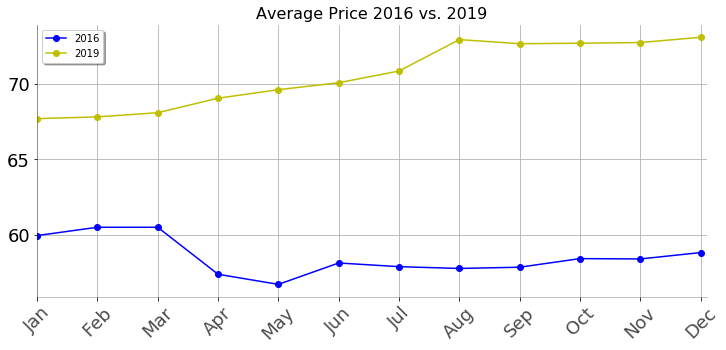

In [193]:
line_style = {1: 'bo-', 2: 'yo-'} 
fig, graph = plt.subplots()

graph.plot('month', 'mean', line_style[1], data=df_16, label = '2016')
graph.plot('month', 'mean', line_style[2], data=df_19, label = '2019')
plt.xticks(ticks=range(0, df_16.shape[0]),labels=df_16['month'], rotation=45, fontsize=18, alpha=.7)

fig.set_size_inches(12, 5)
graph.legend(shadow = True)
graph.grid()
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.title("Average Price 2016 vs. 2019", fontsize=16)
plt.xlim([0,11.1])
plt.show()
# plt.savefig('average_price_2016_vs_2019.png')

In [194]:
popular_types = df_listings['property_type'].value_counts()[:6] # popular property types
popular_types

Apartment             21874
Condominium             621
Loft                    497
House                   479
Serviced apartment      334
Hostel                  223
Name: property_type, dtype: int64

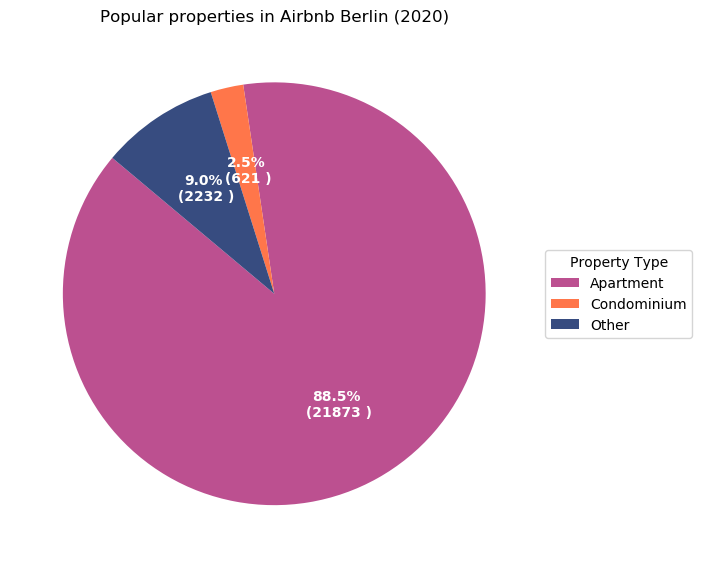

In [195]:
df = df_listings.copy(deep=True)
df['property_type'] = df['property_type'].apply(lambda t: t if (t=='Apartment' or t=='Condominium') else 'Other' )

df = df.groupby('property_type').size().reset_index(name='counts')

# draw plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 100)

data = df['counts']
categories = df['property_type']

def func(pct, allvals):
    """
    Return a formatted string as a label to the wedges with their numeric value.
    """
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  colors=['#bc5090','#ff764a','#374c80'],
                                  textprops=dict(color="w"),
                                  startangle=140)

# decoration
ax.legend(wedges, categories, title="Property Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Popular properties in Airbnb Berlin (2020)")
plt.show()

In [196]:
popular_neigh = df_listings['neighbourhood'].value_counts()[:5] # popular neighbourhoods
popular_neigh

Neukölln           3539
Prenzlauer Berg    3132
Friedrichshain     2877
Kreuzberg          2868
Mitte              2355
Name: neighbourhood, dtype: int64

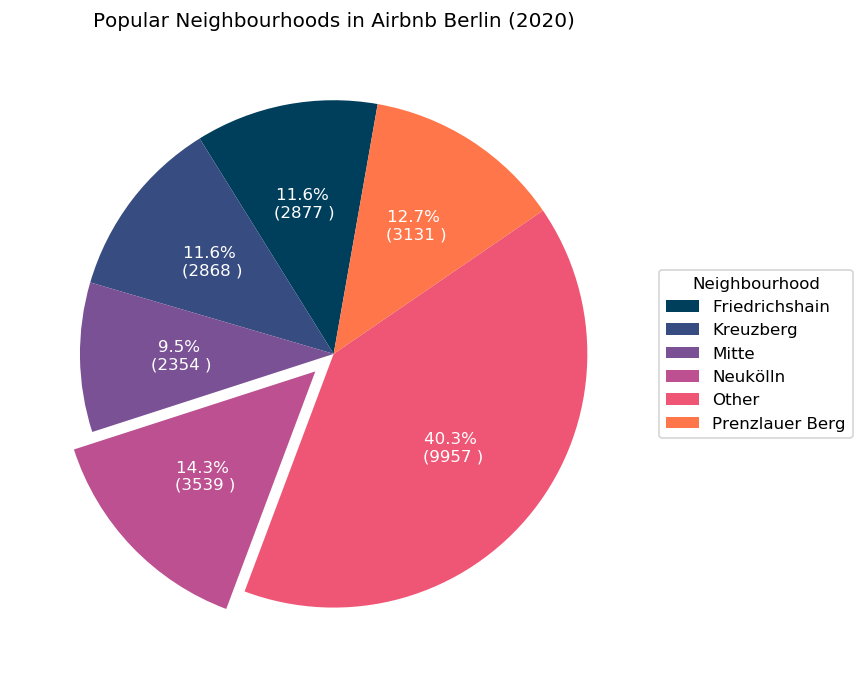

In [197]:
df = df_listings.copy(deep=True)
df['neighbourhood'] = df['neighbourhood'].apply(lambda t: t if (t in popular_neigh) else 'Other' )

df = df.groupby('neighbourhood').size().reset_index(name='counts')

# draw plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 120)

data = df['counts']
categories = df['neighbourhood']
explode = explode = (0, 0, 0, 0.1,0,0)

wedges, texts, autotexts = ax.pie(data,
                                  explode=explode,
                                  labels = df['neighbourhood'],
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors = ['#003f5c','#374c80','#7a5195','#bc5090','#ef5675','#ff764a','#ffa600'],
                                 startangle=80)

# Decoration
ax.legend(wedges, categories, title="Neighbourhood", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Popular Neighbourhoods in Airbnb Berlin (2020)")
plt.show()

In [198]:
calendar_usecols_list = ['listing_id', 'date', 'available', 'price']
df_calendar20 = pd.read_csv('datasets/calendar_2020-04-17.csv', usecols = calendar_usecols_list)
df_calendar20['price'] = df_calendar20['price'].str.replace('[$\,]','').astype('float64')
df_calendar20.head()

,listing_id,date,available,price
0,204617,2020-04-21,f,50.0
1,116832,2020-04-18,f,70.0
2,116832,2020-04-19,f,70.0
3,116832,2020-04-20,f,70.0
4,116832,2020-04-21,f,70.0


In [199]:
df_calendar20['date'] = pd.to_datetime(df_calendar20['date'])
df_calendar20['month'] = df_calendar20['date'].dt.month
df_calendar20.head()

,listing_id,date,available,price,month
0,204617,2020-04-21,f,50.0,4
1,116832,2020-04-18,f,70.0,4
2,116832,2020-04-19,f,70.0,4
3,116832,2020-04-20,f,70.0,4
4,116832,2020-04-21,f,70.0,4


In [200]:
listings_usecols_list = ['id', 'property_type', 'accommodates']
df_listings20 = pd.read_csv('datasets/listings_2020-04-17.csv', usecols = listings_usecols_list)
df_listings20.rename(columns = {'id' : 'listing_id'}, inplace = True)

df = pd.merge(df_calendar20, df_listings20, on = 'listing_id', how = 'left')
df['price_per_person'] = df['price'] / df['accommodates']
df.head()

,listing_id,date,available,price,month,property_type,accommodates,price_per_person
0,204617,2020-04-21,f,50.0,4,Apartment,2,25.000000
1,116832,2020-04-18,f,70.0,4,Apartment,3,23.333333
2,116832,2020-04-19,f,70.0,4,Apartment,3,23.333333
3,116832,2020-04-20,f,70.0,4,Apartment,3,23.333333
4,116832,2020-04-21,f,70.0,4,Apartment,3,23.333333


In [201]:
means = df.groupby(['property_type', 'month'])['price'].mean().unstack(0)
means.head()

property_type,Aparthotel,Apartment,Barn,Bed and breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Castle,...,Lighthouse,Loft,Other,Pension (South Korea),Serviced apartment,Tiny house,Tipi,Townhouse,Treehouse,Villa
month,,,,,,,,,,,,,,,,,,,,,
1,152.731924,78.175230,41.587097,61.270818,235.014663,209.473809,73.130184,69.336406,47.094086,87.5,...,65.000000,128.140391,66.947818,81.754032,155.116960,68.426799,32.000000,79.886061,83.000000,135.575269
2,218.323892,76.376501,41.607143,61.179402,235.012987,269.245740,72.727041,67.551020,46.869048,87.5,...,65.000000,127.731101,67.126050,78.750000,153.157720,68.395604,32.000000,79.740826,83.000000,135.537698
3,222.008899,75.521974,41.780645,61.395349,235.011730,267.806452,72.986175,67.511521,47.975806,87.5,...,65.000000,127.911534,67.188805,78.750000,141.277767,68.521092,32.000000,79.831311,83.000000,135.930108
4,189.942792,75.762308,41.840000,59.857805,236.241692,212.004275,72.272189,66.619048,47.283747,87.5,...,65.333333,124.659153,70.828794,79.145833,167.422116,68.966752,27.600000,79.050213,83.032967,134.758303
5,152.232481,76.724130,41.741935,60.156789,233.319648,138.264871,72.402074,68.645161,45.604839,87.5,...,65.000000,123.680859,69.695446,93.870968,202.559880,71.689826,20.032258,77.967446,84.903226,134.872760


In [202]:
means = means[popular_types.index.tolist()]
means.head()

property_type,Apartment,Condominium,Loft,House,Serviced apartment,Hostel
month,,,,,,
1,78.175230,72.275570,128.140391,76.868207,155.116960,78.052365
2,76.376501,71.881643,127.731101,76.749404,153.157720,77.952274
3,75.521974,71.921459,127.911534,76.657149,141.277767,82.864892
4,75.762308,70.878059,124.659153,76.124074,167.422116,127.015311
5,76.724130,70.317334,123.680859,74.556132,202.559880,77.256184


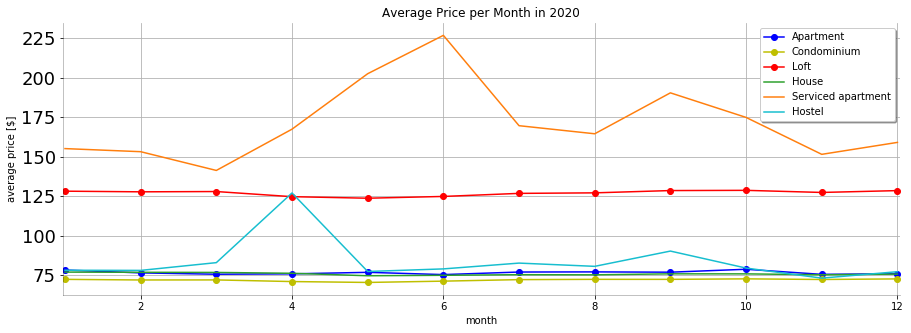

In [203]:
#Creating variable that will support the plotting
fmt_lines_dictionary = {1: 'bo-', 2: 'yo-', 3: 'ro-', 4: 'tab:green', 5: 'tab:orange', 6: 'tab:cyan'} 
fig, graph = plt.subplots()
count = 1

#Input of data
for t in means.columns:
    data = means[t]
    x    = data.index
    y    = list(data)
    graph.plot(x, y, fmt_lines_dictionary[count], label = t)
    count += 1

#Setting of charts
fig.set_size_inches(15, 5)
graph.legend(shadow = True)
graph.set(xlabel = 'month', ylabel = 'average price [$]', xlim=[.97,12.03], title = 'Average Price per Month in 2020')
graph.grid()
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3) 
plt.show()

In [204]:
df = pd.read_csv('datasets/reviews_2020-04-17.csv', low_memory=False)
df.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments
527078,43067472,621818510,2020-04-05,11736601,Najda,Samra is a great host. She is very caring pers...
527079,43070379,621646024,2020-04-03,56391149,Christian,Wszystko w najlepszym porządku...:))\nSzczegól...
527080,43078465,621816757,2020-04-05,342933470,Graziela,Muito bom
527081,43085548,622509889,2020-04-16,28045664,Sarp,"Good location, the place is clean, I'd recomme..."
527082,43108263,622202935,2020-04-11,343502876,Артур,Адреса не вврна


In [205]:
df['parsed_date'] = pd.to_datetime(df['date'])
df = df[df['parsed_date'] > pd.to_datetime('2016-01-01')]
df['year'] = df['parsed_date'].dt.year
df['month'] = df['parsed_date'].dt.month
counts = df.groupby(['year','month'])['listing_id'].count().unstack(0)

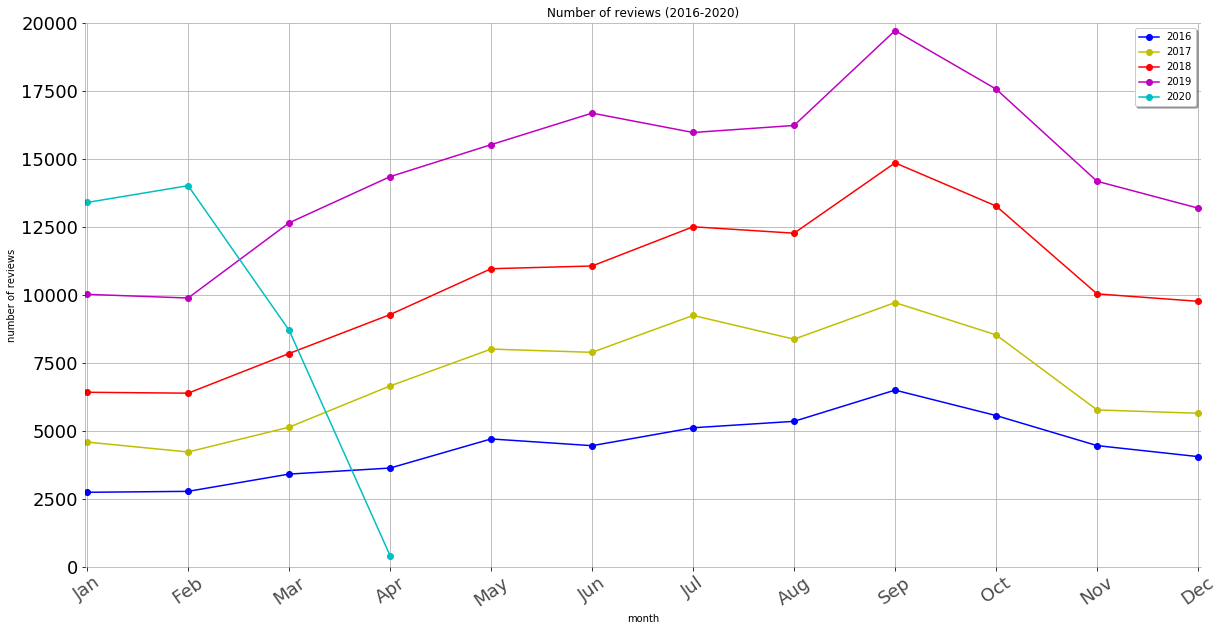

In [206]:
line_style = {1: 'bo-', 2: 'yo-', 3: 'ro-', 4: 'mo-', 5: 'co-'} 
fig, graph = plt.subplots()
count = 1

for year in counts.columns:
    data = counts[year]
    x    = data.index
    y    = list(data)
    graph.plot(x, y, line_style[count], label = year)
    count += 1

labels = [get_month(str(i)) for i in range(1,13)]
plt.xticks(ticks=range(1, counts.shape[0]+1),labels=labels, rotation=35, fontsize=18, alpha=.7)


fig.set_size_inches(20, 10)
graph.legend(shadow = True)
graph.set(xlabel = 'month', ylabel = 'number of reviews', xlim=[.98,12.03], ylim=[0,20_000], title = 'Number of reviews (2016-2020)')
plt.rc('ytick', labelsize=18) 
graph.grid()
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3) 

# plt.show()
plt.savefig('reviews_2016_2020.png')

We can see that every year prices vary in same way throughout the year, every year. However, we can see that 2020 had a drastic impact because of COVID-19

In [172]:
df['year_month'] = df['parsed_date'].dt.strftime('%Y %m')

def year_month(date):
    """
    Return abbreviated year month by given a datetime.
    """
    label = date.strftime('%Y %m')
    label = label[2::]
    return label[:-2] + get_month(label[-2:])

df['year_month_str'] = df['parsed_date'].apply(year_month)

counts = df.groupby(['year_month', 'year_month_str'])['listing_id'].count()
counts = counts.to_frame().reset_index().rename(columns={'listing_id' : 'count'})
counts

,year_month,year_month_str,count
0,2016 01,16 Jan,2737
1,2016 02,16 Feb,2772
2,2016 03,16 Mar,3407
3,2016 04,16 Apr,3629
4,2016 05,16 May,4700
5,2016 06,16 Jun,4452
6,2016 07,16 Jul,5111
7,2016 08,16 Aug,5348
8,2016 09,16 Sep,6497
9,2016 10,16 Oct,5561


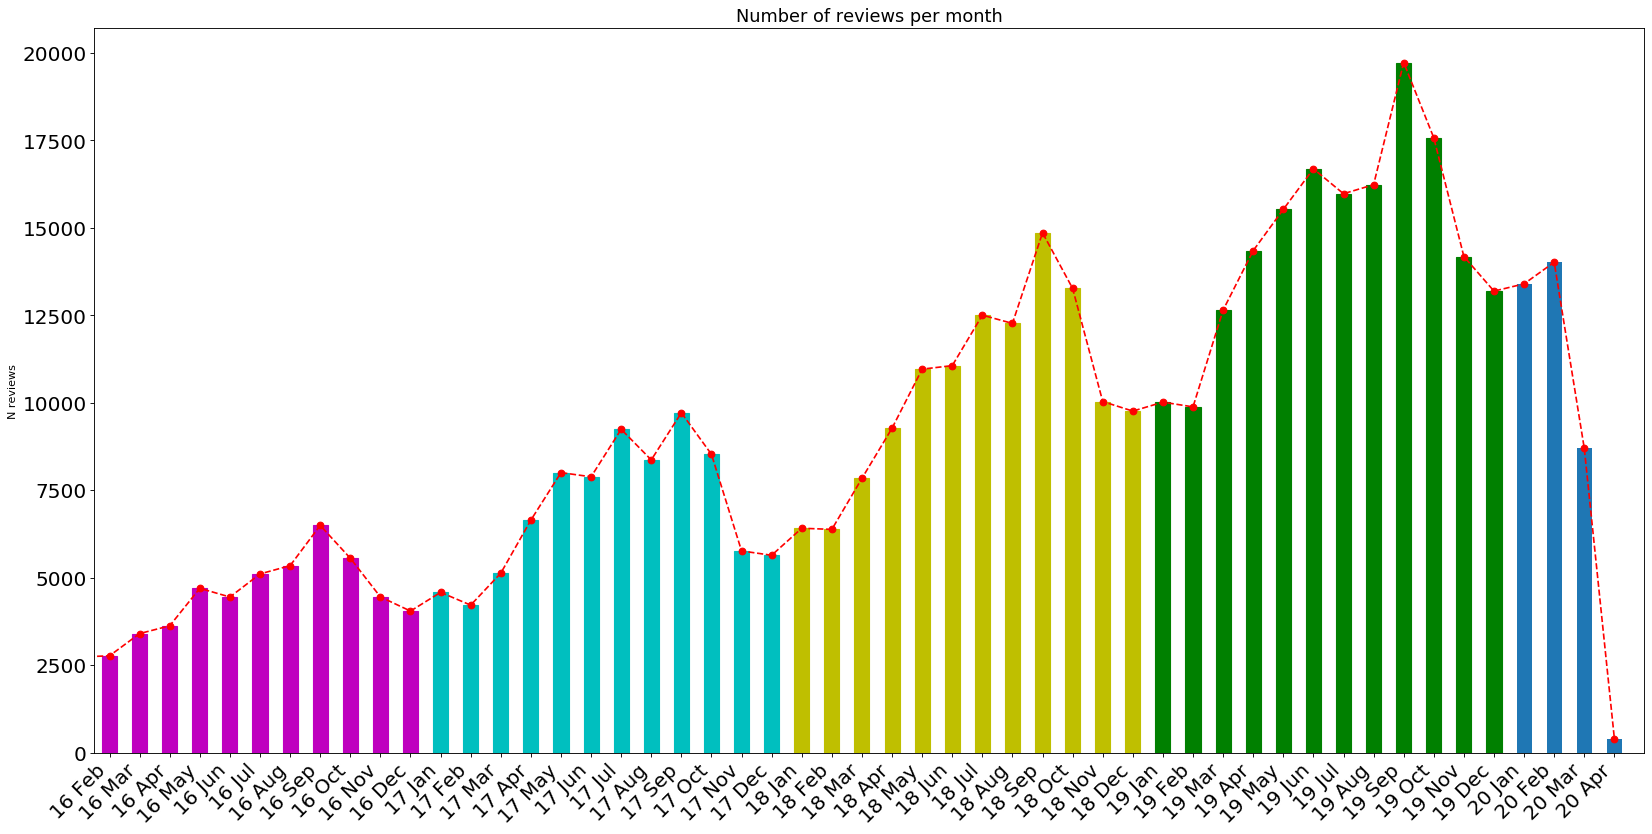

In [173]:
df=counts 

plt.figure(figsize=(25,12), dpi= 80)
bars = plt.bar(df['year_month'], df['count'], width=.5)

for i in range(12):
    bars[i].set_color('m')
for i in range(12,24):
    bars[i].set_color('c')
for i in range(24,36):
    bars[i].set_color('y')
for i in range(36, 48):
    bars[i].set_color('g')

plt.gca().set_xticklabels(df['year_month_str'], rotation=45, horizontalalignment= 'right', fontsize=18)
plt.title("Number of reviews per month", fontsize=16)
plt.ylabel('N reviews')
plt.rc('ytick', labelsize=18) 
plt.plot(df['year_month'], df['count'], 'ro--')
plt.xlim([0.5, df['year_month_str'].shape[0]])
# plt.show()
plt.savefig('activity_per_month_since_2016.png')

We can observe spikes during the summer, in July, August, September every year. We can also observe a steady increasing in number of reviews per each year, that reveals that increase in Airbnb adoption in Berlin.

# Evaluation and Conclusions

Avoid Wilmesdorf because is the most expensive neighbourhood by far. Book in advance if you’re going to visit Berlin in the summer, AirBnB can be very competitive at this time. In case you want plenty of diverse options like bars, restaurants and nightclubs, you should stay in Neukölln or Prenzlauer Berg.
AirBnB prices are increasing each year, which can a be considered good news if you are a host. Fortunately though, prices increase slowly when compared to housing and renting indexes, which have had lots of speculation in recent years.
Lastly, a very sad story for AirBnB is the fact that COVID-19 has hit hard the platform early this year.